# Lesson6 ニューラルネットに画像を生成させよう

## 目次

- Section1 解説
  - 1.1 深層生成モデル
  - 1.2 GAN
- Section2 実装①
  - 2.1 FashionMNISTを用いたGAN
- Section3 テクニック・発展的内容
  - 3.1 Conditional GAN
- Section4　実装②
  - 4.1 FashionMNISTを用いたConditional GAN
- Section5 参考
  - 5.1 VAE
- Section6 ケーススタディ

In [1]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test

def plot_mnist(n_ex=10,dim=(2,5), figsize=(8,4)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Section1 解説

### 1.1 深層生成モデル

この回では**深層生成モデル**を使って画像を生成します。

生成モデルとは「データセットを生成する確率分布をモデル化するアプローチ」で、深層生成モデルとは「その確率分布を深層ニューラルネットワークでモデル化するアプローチ」になります。今回は深層生成モデルの中でも代表的な**Generative Adversarial Network (GAN)**と呼ばれるモデルを使って画像を生成してみます。

生成モデルを用いると、データセットが持つ抽象的な表現をモデル化しそのデータセットにありそうなデータを生成することが出来ます。
言葉を変えると、データセットを生成する確率分布を学習することになります。

例えば、MNISTの手書き文字のデータセットの特徴、つまり「手書きの数字」の特徴を捉え、似たような画像を生成することが出来ます。

さて、生成モデルの利用方法として「サンプリング」、「密度推定」、「欠損値補完」などがあります。

- サンプリング: 確率モデルを利用して未知のデータを生成出来る。
- 密度推定: 外れ値検知や異常検知などに用いられる。
- 欠損値補完: 欠損のあるデータを入力して真のデータの推定値が得られる。

などが考えられます。特にサンプリングで未知のデータを生成することから「生成モデル」と呼ばれています。


なお、今回は画像の生成を扱いますが、生成モデル自体は画像の生成に限定されるものではありません。

それではまずはニューラルネットがMNISTの手書き文字を生成できるように学習させてみましょう。

### 1.2 GAN

### 1.2.1 GANの概要

GANではGeneratorとDiscriminatorと呼ばれる2つのネットワークが登場します。

Generatorはデータセットと同じような画像を生成しようとします。
一方、Discriminatorは入力画像がデータセットの中にある本物の画像かGeneratorが生成した偽物の画像かどうかを判定します。

GeneratorはよりDiscriminatorを騙すことの出来る本物に近いデータを生成しようと学習し、Discriminatoは真偽を見分けることが出来るように学習します。
この両ネットワークの相乗効果によってGeneratorにはデータセットにある画像と似ている画像が生成されることが期待されます。

GANは比較的くっきりとした画像が生成されることが特徴にありますが、学習が不安定なところが短所になります。

<img src='figures/gan1.png' alt='gan_1'>

次に具体的にどのように学習を進めていくかを数式を交えて説明します。

以下の式を見て下さい。 

$\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z)))]$ 
([Generative Adversarial Networks](https://arxiv.org/abs/1406.2661))

Discriminatorの出力の$D(x)$ は入力画像が訓練データのものであるかどうかの予測確率を表しています。Discriminatorは $D(x)$を最大化、また$G(z)$　は生成されたデータなので $1-D(G(z)))$ の最大化を行います。Generatorは逆に最小化を行います。そのため、Generatorの学習が進むと、Discriminatorは正しく判定しにくくなります。


つまり、

1. Generatorは、学習においてDiscrimnatorの学習とは独立に $V(D, G)$ を最小化するように学習します。
2. Discriminatorは、学習においてGeneratorの学習とは独立に $V(D, G)$ を最大化するように学習します。


学習を交互に行うことで両者の学習を進めていくことになります。

なお、GANの収束性については現在も研究が進められていますが、依然として学習が不安定なので、ネットワークを設計する際は、論文のネットワークの形をそのまま利用したり、実際の実装コードを参考にしたりすると良いです。

それでは具体的な実装をみていきましょう。

### 1.2.2 Generator

まず、Generatorのネットワークを構築します。

Generatorではランダムに生成したノイズからデータセットにあるような本物っぽい画像を生成することが目的です。
つまり、出力した画像に対してDiscriminatorが本物と勘違いするように学習します。

ここでは要素の100のノイズを入力として、サイズ28x28でチャンネル1の画像を出力にしています。

Generatorの中には `UpSampling2D` というレイヤーが登場するのですが、通常の畳込みの逆演算として使用しています。つまり入力のwidth及びheightを増加させるように作用します。

In [2]:
from tensorflow.keras.layers import Input, Reshape, Dense, Flatten, Activation, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def Generator():
    nch = 200
    model_input = Input(shape=[100])
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(model_input) # 100 -> 200*14*14
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x) # 200*14*14 -> 14x14x200 (width)x(height)x(channel)
    x = UpSampling2D(size=(2, 2))(x) # 14x14x200 -> 28x28x200
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x200 -> 28x28x100
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x100 -> 28x28x50
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x50 -> 28x28x1
    model_output = Activation('sigmoid')(x)
    model = Model(model_input, model_output)
    # model.summary()
    
    return model

### 1.2.3 Discriminator

次にDiscriminatorのネットワークを構築します。

データセットの画像が入力されれば本物であると、Generatorによって出力されたデータであれば偽物であると判定するように学習させます。

入力としてはサイズ28x28でチャンネル1の画像を入力にして、その画像がデータセットにある本物データかどうかを2値で出力します。

なお、[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) にてDiscriminatorのActivationとしてはLeakyReLUを利用するとよい結果が出ることが言及されているのでこれを使用します。(LeakyReLUとはReLUの負の領域に対しても微小な勾配を可能にするReLUの特別版です。)

In [3]:
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    model_input = Input(shape=shape) # 28x28x1
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(model_input) # 28x28x1 -> 14x14x256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x) # 14x14x256 -> 7x7x512
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x) # 7x7x512 -> 7*7*512
    x = Dense(256)(x) # 7*7*512 -> 256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x) # 256 -> 2
    model = Model(model_input, model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

### 1.2.4 GANの学習

combined_networkの関数はGeneratorの学習時に使用します。Generatorの学習ではDiscriminatorの出力を目的関数とするのでGeneratorとDiscriminatorを繋げたネットワークで学習する必要があります。

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    x = generator(gan_input)
    gan_output = discriminator(x)
    model = Model(gan_input, gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

次に、モデルを学習を制御する関数のmake_trainableを定義します。

GeneratorとDiscriminatorはそれぞれ独立に学習をするため、combined_networkでGeneratorの学習を目的とする場合、
Discriminatorが一緒に学習しないようにする必要があります。
そのときに利用するのがこの関数です。

Discriminatorの各Layerのtrainableというメソッドの値をすべてFalseにすることができ、パラメータを更新しないようにすることが出来ます。
この後のtrain関数内で利用します。

In [5]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

以下のtrain関数で実際に学習を進めていきます。

train関数内では以下のような学習を各バッチごとに行います。

1. バッチの学習で利用する画像の選択
2. Discriminatorの学習をonに切り替える
3. Generatorによる生成画像を用いてDiscriminatorの学習
4. Discriminatorの学習をoffに切り替える
5. Generatorの学習

In [6]:
from tqdm import tqdm

def train(step=3000, BATCH_SIZE=128):
    for e in tqdm(range(step)):
        # 1. バッチの学習で利用する画像の選択 
        # バッチサイズの分だけランダムに画像を選択
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]
        
        # バッチサイズの分だけランダムにノイズを生成し、generatorにより画像を生成
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # 2. Discriminatorの学習をonに切り替える
        # Discriminatorが学習するように変更
        make_trainable(discriminator,True)
        
        # 3. Generatorによる生成画像を用いてDiscriminatorの学習
        # X = (バッチサイズ分のデータセットの画像, バッチサイズ分の生成画像)
        X = np.concatenate((image_batch, generated_images))
        
        # y = (バッチサイズ分のTrue(本物), バッチサイズ分のFalse(偽物))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1      
        
        # Discriminatorのtrain
        discriminator.train_on_batch(X,y)
        
        # 4. Discriminatorの学習をoffに切り替える
        # Discriminatorが学習しないように変更
        make_trainable(discriminator,False)
    
        # 5. Generatorの学習
        # バッチサイズの分だけランダムにノイズを生成
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        
        # y = (バッチサイズ分のTrue(本物))
        # 実際には生成した画像なのでDiscriminatorとしては偽物と判断すべきだが、Genaratorの学習なので生成した画像を本物と判断するように学習させる
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        # Generatorのtrain
        GAN.train_on_batch(noise_gen, y2 )

### 1.2.5 MNISTによる学習

In [7]:
# データのロード
X_train, _,_,_ = load_mnist()
# それぞれのネットワークのインスタンスを生成
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
# train関数で学習を行うstepを大きくすると学習をより多く行います
train()

100%|██████████| 3000/3000 [11:58<00:00,  4.17it/s]


### 1.2.6 手書き文字の生成

学習が出来たら、実際にランダムのノイズから手書き文字のような画像が出力されるか表示して確認してみましょう。

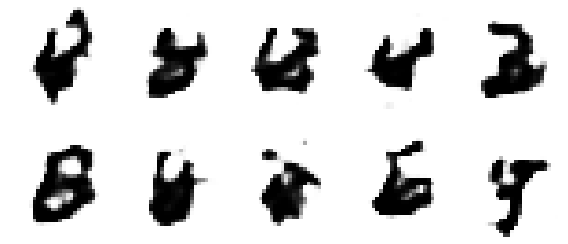

In [9]:
plot_mnist()

## Checkクイズ

- 問題1
    - GANに関して、次の選択肢から最も適切なものを一つ選びなさい
- 選択肢
    1. Generatorはデータセットと同じような画像を生成する。DiscriminatorはGeneratorで生成した画像を精錬した画像を出力する。
    2. Generatorはデータセットと同じような画像を生成する。Discriminatorは入力画像がデータセットの中にある本物の画像かGeneratorが生成した偽物の画像かどうかを判定する。
    3. Discriminatorはデータセットと同じような画像を生成する。GeneratorはGeneratorで生成した画像を精錬した画像を出力する。
    4. Discriminatorはデータセットと同じような画像を生成する。Generatorは入力画像がデータセットの中にある本物の画像かDiscriminatorが生成した偽物の画像かどうかを判定する。

- 問題2
    - GANとして最も適切なものを一つ選びなさい
- 選択肢
    1. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{z{\sim}p_{data}(z)}[\log(D(G(z)))]$ 
    2. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{x{\sim}p_{data}(x)}[\log G(x)]$ 
    3. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z)))]$ 
    4. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{x{\sim}p_{data}(x)}[\log(1-D(G(x)))]$ 

In [ ]:
②③